Here's a **10-line explanation** of the code that will be executed as part of this notebook:

1. **Read and preprocess PDF**: Loads and extracts text from a PDF file using `PyPDF`, filtering out empty pages.
2. **Split text**: First splits large text into manageable chunks using `RecursiveCharacterTextSplitter`, then refines these chunks based on token count with `SentenceTransformersTokenTextSplitter`.
3. **Embed text**: Initializes a `SentenceTransformerEmbeddingFunction` and creates a Chroma vector store (`chromadb`) to embed and store the processed text.
4. **Indexing**: Each chunk is embedded and added to a Chroma collection with unique IDs.
5. **Querying**: A natural language query is used to retrieve top-matching document chunks based on vector similarity.
6. **Query augmentation**: The query is enhanced using OpenAI’s GPT model to generate a hypothetical answer, creating a more informative "joint query."
7. **Re-query**: The joint query is re-run on the vector store to retrieve even more contextually relevant documents.
8. **Embeddings for visualization**: Embeddings of the dataset, query, and results are reduced to 2D using UMAP for plotting.
9. **Visualization**: Matplotlib is used to plot the embedding space, showing the dataset, query, and retrieved document positions.
10. **Purpose**: This process builds a mini-RAG (Retrieval-Augmented Generation) pipeline with visual insight into how queries relate to embedded document content.


In [ ]:
pip install umap

In [3]:
from helper_utils import project_embeddings, word_wrap
from pypdf import PdfReader
import os
from openai import OpenAI
from dotenv import load_dotenv

from pypdf import PdfReader
import umap


# Load environment variables from .env file
load_dotenv()

openai_key = os.getenv("OPENAI_API_KEY")
client = OpenAI(api_key=openai_key)

reader = PdfReader("data/microsoft-annual-report.pdf")

In [6]:
type(reader)
print(reader.pages)

[PageObject(0), PageObject(1), PageObject(2), PageObject(3), PageObject(4), PageObject(5), PageObject(6), PageObject(7), PageObject(8), PageObject(9), PageObject(10), PageObject(11), PageObject(12), PageObject(13), PageObject(14), PageObject(15), PageObject(16), PageObject(17), PageObject(18), PageObject(19), PageObject(20), PageObject(21), PageObject(22), PageObject(23), PageObject(24), PageObject(25), PageObject(26), PageObject(27), PageObject(28), PageObject(29), PageObject(30), PageObject(31), PageObject(32), PageObject(33), PageObject(34), PageObject(35), PageObject(36), PageObject(37), PageObject(38), PageObject(39), PageObject(40), PageObject(41), PageObject(42), PageObject(43), PageObject(44), PageObject(45), PageObject(46), PageObject(47), PageObject(48), PageObject(49), PageObject(50), PageObject(51), PageObject(52), PageObject(53), PageObject(54), PageObject(55), PageObject(56), PageObject(57), PageObject(58), PageObject(59), PageObject(60), PageObject(61), PageObject(62), P

In [8]:
pdf_texts = [p.extract_text().strip() for p in reader.pages]
type(pdf_texts)

list

In [9]:
pdf_texts[1:5]

['Dear shareholders, colleagues, customers, and partners,  \nWe are living through a time of historic challenge and opportunity. As I write this, the world faces ongoing economic, \nsocial, and geopolitical volatility. At the same time, we have entered a new age of AI that will fundamentally transform \nproductivity for every individual, organization, and industry on earth, and help us address some of our most pressing \nchallenges.  \nThis next generation of AI will reshape every software category and every business, including our own. Forty-eight years \nafter its founding, Microsoft remains a consequential company because time and time again—from PC/Server, to Web/\nInternet, to Cloud/Mobile—we have adapted to technological paradigm shifts. Today, we are doing so once again, as we \nlead this new era.  \nAmid this transformation, our mission to empower every person and every organization on the planet to achieve \nmore remains constant. As a company, we believe we can be the democra

In [10]:
from langchain.text_splitter import (RecursiveCharacterTextSplitter, SentenceTransformersTokenTextSplitter)

In [11]:
character_splitter = RecursiveCharacterTextSplitter?

Init signature:
RecursiveCharacterTextSplitter(
    separators: 'Optional[List[str]]' = None,
    keep_separator: "Union[bool, Literal['start', 'end']]" = True,
    is_separator_regex: 'bool' = False,
    **kwargs: 'Any',
) -> 'None'
Docstring:     
Splitting text by recursively look at characters.

Recursively tries to split by different characters to find one
that works.
Init docstring: Create a new TextSplitter.
File:           c:\users\somashekar.inguva\onedrive - telstra\documents\genai_projects\venv_genai\lib\site-packages\langchain_text_splitters\character.py
Type:           ABCMeta
Subclasses:     JSFrameworkTextSplitter, LatexTextSplitter, MarkdownTextSplitter, PythonCodeTextSplitter

In [12]:
character_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", ". ", " ", ""],chunk_size=1000,chunk_overlap=0)

In [13]:
character_split_texts = character_splitter.split_text("\n\n".join(pdf_texts))

In [14]:
type(character_split_texts)

list

In [15]:
len(character_split_texts)

350

In [17]:
print(word_wrap(character_split_texts[10]))

Industry  
Across industries, we are rapidly becoming the partner of choice for any org
anization looking to generate real value from 
AI. In healthcare, for example, we intro
duced the world’s first fully automated clinical documentation application, DAX 
Copilo
t. The application helps physicians reduce documentation time by half, freeing them to 
spend more time face to 
face with patients. And Epic will integrate it directly into i
ts electronic health records system.  
And, in retail, we introduced new tools to help 
companies manage their day-to-day operations and digitize their physical 
stores.  
Mod
ern work  
We are rapidly evolving Microsoft 365 into an AI-first platform that enables
 every individual to amplify their creativity and 
productivity, with both our establis
hed applications like Office and Teams, as well as new apps like Designer, Stream, and 

Loop. Microsoft 365 is designed for today’s digitally connected, distributed workforce
.


In [24]:
len(character_split_texts[10]),len(character_split_texts[15])

(958, 962)

In [19]:
character_split_texts[0:2]

['Dear shareholders, colleagues, customers, and partners,  \nWe are living through a time of historic challenge and opportunity. As I write this, the world faces ongoing economic, \nsocial, and geopolitical volatility. At the same time, we have entered a new age of AI that will fundamentally transform \nproductivity for every individual, organization, and industry on earth, and help us address some of our most pressing \nchallenges.  \nThis next generation of AI will reshape every software category and every business, including our own. Forty-eight years \nafter its founding, Microsoft remains a consequential company because time and time again—from PC/Server, to Web/\nInternet, to Cloud/Mobile—we have adapted to technological paradigm shifts. Today, we are doing so once again, as we \nlead this new era.  \nAmid this transformation, our mission to empower every person and every organization on the planet to achieve',
 'more remains constant. As a company, we believe we can be the democ

In [20]:
token_splitter = SentenceTransformersTokenTextSplitter?

Init signature:
SentenceTransformersTokenTextSplitter(
    chunk_overlap: 'int' = 50,
    model_name: 'str' = 'sentence-transformers/all-mpnet-base-v2',
    tokens_per_chunk: 'Optional[int]' = None,
    **kwargs: 'Any',
) -> 'None'
Docstring:      Splitting text to tokens using sentence model tokenizer.
Init docstring: Create a new TextSplitter.
File:           c:\users\somashekar.inguva\onedrive - telstra\documents\genai_projects\venv_genai\lib\site-packages\langchain_text_splitters\sentence_transformers.py
Type:           ABCMeta
Subclasses:     

## Selfnotes:
Question: is it good option to use over RecursiveCharacterTextSplitter while splitting the texts ? or both are of different usecase ? 

Answer: 
Great question — whether to use `SentenceTransformersTokenTextSplitter` or `RecursiveCharacterTextSplitter` depends on your **use case**, the **models you're working with**, and your goals for **text splitting**. Here's a detailed comparison to help you decide:

---

### 🔀 **High-Level Comparison**

| Feature                          | `SentenceTransformersTokenTextSplitter`                          | `RecursiveCharacterTextSplitter`                                                |
| -------------------------------- | ---------------------------------------------------------------- | ------------------------------------------------------------------------------- |
| **Splitting Basis**              | Token count using SentenceTransformer tokenizer                  | Character-based with recursive rules (e.g. "\n\n", "\n", ".", " ")              |
| **Model Awareness**              | ✅ Yes – tokenizes based on actual model tokenizer                | ❌ No – doesn't know about tokens or model limits                                |
| **Best for**                     | Embedding models (e.g., SBERT, MiniLM) where token limits matter | General-purpose splitting when tokenization isn't a concern                     |
| **Maintains Semantic Integrity** | ✅ Yes (sentence-level, avoids cutting in the middle of thoughts) | ⚠️ Maybe – depends on how well text structure aligns with the fallback strategy |
| **Customizability**              | Moderate (based on tokenizer and chunk sizes)                    | Highly flexible with fallback hierarchy                                         |

---

### 🧠 Use Case Breakdown

#### ✅ **Use `SentenceTransformersTokenTextSplitter` if:**

* You're preparing **text for embedding** using a SentenceTransformer model.
* You want to ensure **chunks stay within token limits** (e.g. 512 tokens).
* You care about **semantic continuity** in chunks (to avoid splitting sentences unnaturally).

#### ✅ **Use `RecursiveCharacterTextSplitter` if:**

* You're working with **non-token-based models**, or just want to split text intelligently for display, summarization, etc.
* You want a **hierarchical and flexible** fallback (e.g., try splitting by paragraphs first, then sentences, then words).
* You don't care about exact token counts, just general chunk length (e.g., 1000 characters).

---

### 🎯 Practical Example

**Document Retrieval + Embedding:**

* Use `SentenceTransformersTokenTextSplitter` to chunk input into **token-aware**, semantically meaningful pieces.
* This ensures your vector database (e.g., FAISS, Pinecone) stores high-quality embeddings.

**Text Summarization or Display UI:**

* Use `RecursiveCharacterTextSplitter` to split large documents into **readable chunks** without necessarily worrying about token count.

---

### 🧪 TL;DR Recommendation

* **Embedding use cases (RAG, search)**: 👉 `SentenceTransformersTokenTextSplitter`
* **General NLP preprocessing / summarization / readability**: 👉 `RecursiveCharacterTextSplitter`

---

 ## Summary
character_split_texts: chunks ~1000 characters each, semantically aware, helps break big documents down.

Later: further refined into token_split_texts of max 256 tokens for model compatibility.

In [29]:
token_splitter = SentenceTransformersTokenTextSplitter(
    chunk_overlap=0, tokens_per_chunk=256
)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

c:\Users\somashekar.inguva\OneDrive - Telstra\Documents\GenAI_Projects\venv_GenAI\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\somashekar.inguva\.cache\huggingface\hub\models--sentence-transformers--all-mpnet-base-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [31]:
token_split_texts = []
for text in character_split_texts:
    token_split_texts += token_splitter.split_text(text)

In [33]:
type(token_split_texts)
token_split_texts[0]

'dear shareholders, colleagues, customers, and partners, we are living through a time of historic challenge and opportunity. as i write this, the world faces ongoing economic, social, and geopolitical volatility. at the same time, we have entered a new age of ai that will fundamentally transform productivity for every individual, organization, and industry on earth, and help us address some of our most pressing challenges. this next generation of ai will reshape every software category and every business, including our own. forty - eight years after its founding, microsoft remains a consequential company because time and time again — from pc / server, to web / internet, to cloud / mobile — we have adapted to technological paradigm shifts. today, we are doing so once again, as we lead this new era. amid this transformation, our mission to empower every person and every organization on the planet to achieve'

In [37]:
print(word_wrap(token_split_texts[10]))
print(f"\nTotal chunks: {len(token_split_texts)}")

industry across industries, we are rapidly becoming the partner of choice for any organ
ization looking to generate real value from ai. in healthcare, for example, we introduc
ed the world ’ s first fully automated clinical documentation application, dax copilot.
 the application helps physicians reduce documentation time by half, freeing them to sp
end more time face to face with patients. and epic will integrate it directly into its 
electronic health records system. and, in retail, we introduced new tools to help compa
nies manage their day - to - day operations and digitize their physical stores. modern 
work we are rapidly evolving microsoft 365 into an ai - first platform that enables eve
ry individual to amplify their creativity and productivity, with both our established a
pplications like office and teams, as well as new apps like designer, stream, and loop.
 microsoft 365 is designed for today ’ s digitally connected, distributed workforce.

Total chunks: 359


In [ ]:
print(f"\nTotal chunks: {len(character_split_texts)}") ## without Transformer model , chunking..


Total chunks: 350


In [39]:
print(word_wrap(character_split_texts[10]))

Industry  
Across industries, we are rapidly becoming the partner of choice for any org
anization looking to generate real value from 
AI. In healthcare, for example, we intro
duced the world’s first fully automated clinical documentation application, DAX 
Copilo
t. The application helps physicians reduce documentation time by half, freeing them to 
spend more time face to 
face with patients. And Epic will integrate it directly into i
ts electronic health records system.  
And, in retail, we introduced new tools to help 
companies manage their day-to-day operations and digitize their physical 
stores.  
Mod
ern work  
We are rapidly evolving Microsoft 365 into an AI-first platform that enables
 every individual to amplify their creativity and 
productivity, with both our establis
hed applications like Office and Teams, as well as new apps like Designer, Stream, and 

Loop. Microsoft 365 is designed for today’s digitally connected, distributed workforce
.


In [40]:
import chromadb
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

In [41]:
embedding_function = SentenceTransformerEmbeddingFunction()

In [ ]:
print(embedding_function([token_split_texts[10]]))

In [45]:
chroma_client = chromadb.Client()

In [47]:
chroma_collection = chroma_client.create_collection(
    name="microsoft-collection",embedding_function=embedding_function)

In [49]:
ids = [str(i) for i in range(len(token_split_texts))]

In [51]:
len(ids),len(token_split_texts)

(359, 359)

In [52]:
chroma_collection.add(ids=ids,documents = token_split_texts)
chroma_collection.count()

359

In [55]:
type(chroma_collection)

chromadb.api.models.Collection.Collection

In [ ]:
query = "What was the total revenue for the year?"
##Querying: A natural language query is used to retrieve top-matching document chunks based on vector similarity.

In [59]:
results = chroma_collection.query(query_texts=[query],n_results=5)
results

{'ids': [['153', '328', '330', '193', '201']],
 'embeddings': None,
 'documents': [['general and administrative $ 7, 575 $ 5, 900 28 % as a percent of revenue 4 % 3 % 1ppt 35',
   'segment revenue and operating income were as follows during the periods presented : no sales to an individual customer or country other than the united states accounted for more than 10 % of revenue for fiscal years 2023, 2022, or 2021. revenue, classified by the major geographic areas in which our customers were located, was as follows : ( a ) includes billings to oems and certain multinational organizations because of the nature of these businesses and the impracticability of determining the geographic source of the revenue. ( in millions ) year ended june 30, 2023 2022 2021 revenue productivity and business processes $ 69, 274 $ 63, 364 $ 53, 915 intelligent cloud 87, 907 74, 965 59, 728 more personal computing 54, 734 59, 941 54, 445 total $ 211, 915 $ 198, 270 $ 168, 088 operating income productivity an

In [62]:
retrieved_documents = results["documents"][0]

In [ ]:
for document in retrieved_documents:
    print(word_wrap(document))
    print("\n")

In [65]:
##Query augmentation: The query is enhanced using OpenAI’s GPT model to generate a hypothetical answer, 
# creating a more informative "joint query."

In [66]:
def augment_query_generated(query, model="gpt-3.5-turbo"):
    prompt = """You are a helpful expert financial research assistant. 
   Provide an example answer to the given question, that might be found in a document like an annual report."""
    messages = [
        {
            "role": "system",
            "content": prompt,
        },
        {"role": "user", "content": query},
    ]

    response = client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    return content

In [67]:
original_query = "What was the total profit for the year, and how does it compare to the previous year?"
hypothetical_answer = augment_query_generated(original_query)
hypothetical_answer

'In the current fiscal year, our company reported a total profit of $10 million. This represents a significant increase compared to the previous year, where our profit was $8 million. The 25% increase in profit demonstrates the successful implementation of our strategic initiatives and the overall growth of our business operations.'

In [68]:
joint_query = f"{original_query} {hypothetical_answer}"
print(word_wrap(joint_query))

What was the total profit for the year, and how does it compare to the previous year? I
n the current fiscal year, our company reported a total profit of $10 million. This rep
resents a significant increase compared to the previous year, where our profit was $8 m
illion. The 25% increase in profit demonstrates the successful implementation of our st
rategic initiatives and the overall growth of our business operations.


In [ ]:
# Re-query: The joint query is re-run on the vector store to retrieve even more contextually relevant documents.
results = chroma_collection.query(
    query_texts=joint_query, n_results=5, include=["documents", "embeddings"]
)

In [73]:
retrieved_documents = results["documents"][0]

In [74]:
for doc in retrieved_documents:
    print(word_wrap(doc))
    print("")

sales and marketing expenses increased $ 934 million or 4 % driven by 3 points of growt
h from the nuance and xandr acquisitions and investments in commercial sales, offset in
 part by a decline in windows advertising. sales and marketing included a favorable for
eign currency impact of 2 %. general and administrative general and administrative expe
nses include payroll, employee benefits, stock - based compensation expense, employee s
everance expense incurred as part of a corporate program, and other headcount - related
 expenses associated with ( in millions, except percentages ) 2023 2022 percentage chan
ge research and development $ 27, 195 $ 24, 512 11 % as a percent of revenue 13 % 12 % 
1ppt ( in millions, except percentages ) 2023 2022 percentage change sales and marketin
g $ 22, 759 $ 21, 825 4 % as a percent of revenue 11 % 11 % 0ppt ( in millions, except 
percentages ) 2023 2022 percentage change

change in accounting estimate in july 2022, we completed an assessment of the

In [ ]:
pip install umap-learn

In [ ]:
# Embeddings for visualization: Embeddings of the dataset, query, and results are reduced to 2D using 
# UMAP for plotting.

# Visualization: Matplotlib is used to plot the embedding space, showing the dataset, query, 
# and retrieved document positions.

Had to restart the Kernal after pip install and all variables lost, hence runnign the compelte script below. 

What was the total profit for the year, and how does it compare to the previous year? T
he total profit for the year amounted to $1.5 million, which represents a 10% increase 
compared to the previous year's profit of $1.36 million. This growth can be attributed 
to increased sales and cost-saving initiatives implemented throughout the year.


c:\Users\somashekar.inguva\OneDrive - Telstra\Documents\GenAI_Projects\venv_GenAI\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\somashekar.inguva\OneDrive - Telstra\Documents\GenAI_Projects\venv_GenAI\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\somashekar.inguva\OneDrive - Telstra\Documents\GenAI_Projects\venv_GenAI\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\somashekar.inguva\OneDrive - Telstra\Documents\GenAI_Projects\venv_GenAI\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\

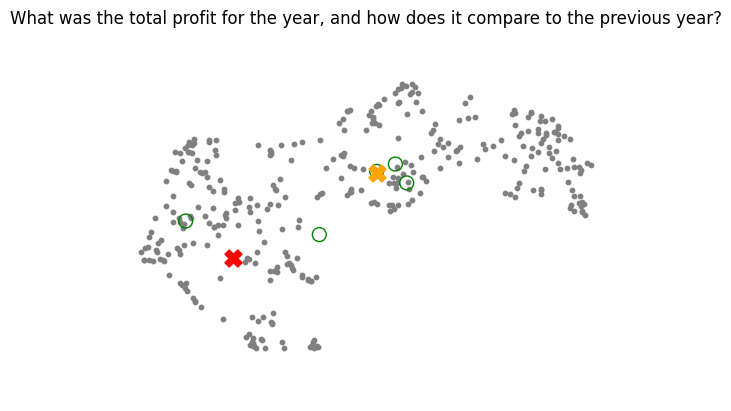

In [2]:
from helper_utils import project_embeddings, word_wrap
from pypdf import PdfReader
import os
from openai import OpenAI
from dotenv import load_dotenv

from pypdf import PdfReader
import umap


# Load environment variables from .env file
load_dotenv()

openai_key = os.getenv("OPENAI_API_KEY")
client = OpenAI(api_key=openai_key)

reader = PdfReader("data/microsoft-annual-report.pdf")
pdf_texts = [p.extract_text().strip() for p in reader.pages]

# Filter the empty strings
pdf_texts = [text for text in pdf_texts if text]
# print(
#     word_wrap(
#         pdf_texts[0],
#         width=100,
#     )
# )

# split the text into smaller chunks


from langchain.text_splitter import (
    RecursiveCharacterTextSplitter,
    SentenceTransformersTokenTextSplitter,
)

character_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", ". ", " ", ""], chunk_size=1000, chunk_overlap=0
)
character_split_texts = character_splitter.split_text("\n\n".join(pdf_texts))

# print(word_wrap(character_split_texts[10]))
# print(f"\nTotal chunks: {len(character_split_texts)}")

token_splitter = SentenceTransformersTokenTextSplitter(
    chunk_overlap=0, tokens_per_chunk=256
)
token_split_texts = []
for text in character_split_texts:
    token_split_texts += token_splitter.split_text(text)

# print(word_wrap(token_split_texts[10]))
# print(f"\nTotal chunks: {len(token_split_texts)}")


import chromadb
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

embedding_function = SentenceTransformerEmbeddingFunction()
# print(embedding_function([token_split_texts[10]]))

chroma_client = chromadb.Client()
chroma_collection = chroma_client.create_collection(
    "microsoft-collection", embedding_function=embedding_function
)

# extract the embeddings of the token_split_texts
ids = [str(i) for i in range(len(token_split_texts))]
chroma_collection.add(ids=ids, documents=token_split_texts)
chroma_collection.count()

query = "What was the total revenue for the year?"


results = chroma_collection.query(query_texts=[query], n_results=5)
retrieved_documents = results["documents"][0]

# for document in retrieved_documents:
#     print(word_wrap(document))
#     print("\n")


def augment_query_generated(query, model="gpt-3.5-turbo"):
    prompt = """You are a helpful expert financial research assistant. 
   Provide an example answer to the given question, that might be found in a document like an annual report."""
    messages = [
        {
            "role": "system",
            "content": prompt,
        },
        {"role": "user", "content": query},
    ]

    response = client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    return content


original_query = "What was the total profit for the year, and how does it compare to the previous year?"
hypothetical_answer = augment_query_generated(original_query)

joint_query = f"{original_query} {hypothetical_answer}"
print(word_wrap(joint_query))

results = chroma_collection.query(
    query_texts=joint_query, n_results=5, include=["documents", "embeddings"]
)
retrieved_documents = results["documents"][0]


# for doc in retrieved_documents:
#     print(word_wrap(doc))
#     print("")

embeddings = chroma_collection.get(include=["embeddings"])["embeddings"]
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)


retrieved_embeddings = results["embeddings"][0]
original_query_embedding = embedding_function([original_query])
augmented_query_embedding = embedding_function([joint_query])

projected_original_query_embedding = project_embeddings(
    original_query_embedding, umap_transform
)
projected_augmented_query_embedding = project_embeddings(
    augmented_query_embedding, umap_transform
)
projected_retrieved_embeddings = project_embeddings(
    retrieved_embeddings, umap_transform
)

import matplotlib.pyplot as plt

# Plot the projected query and retrieved documents in the embedding space
plt.figure()

plt.scatter(
    projected_dataset_embeddings[:, 0],
    projected_dataset_embeddings[:, 1],
    s=10,
    color="gray",
)
plt.scatter(
    projected_retrieved_embeddings[:, 0],
    projected_retrieved_embeddings[:, 1],
    s=100,
    facecolors="none",
    edgecolors="g",
)
plt.scatter(
    projected_original_query_embedding[:, 0],
    projected_original_query_embedding[:, 1],
    s=150,
    marker="X",
    color="r",
)
plt.scatter(
    projected_augmented_query_embedding[:, 0],
    projected_augmented_query_embedding[:, 1],
    s=150,
    marker="X",
    color="orange",
)

plt.gca().set_aspect("equal", "datalim")
plt.title(f"{original_query}")
plt.axis("off")
plt.show()  # display the plot


## Explaination of the above PLot
this plot is a **visualization of the semantic similarity** between your query and the document chunks from the PDF, based on their vector embeddings reduced to 2D using **UMAP**.

Let me explain what each type of dot represents:

---

### 🔘 **Gray Dots**

* **What they are**: These are the **UMAP-projected embeddings of all the document chunks** in your Chroma collection (after token splitting + embedding).
* **Purpose**: They represent the full embedding space of your PDF content — each dot is a chunk of the annual report.

---

### 🟢 **Green Circles (with or without borders)**

* **What they are**: These are the **retrieved document chunks** returned by ChromaDB when you searched with the query.
* **Why they matter**: They are the **most relevant chunks** according to vector similarity (top 5 results).
* May be visualized differently depending on how `plt.scatter` is called (some might be filled, some outlined).

---

### 🟧 **Orange Star**

* **What it is**: This is the **augmented (joint) query embedding**, i.e., the original query combined with a GPT-generated hypothetical answer.
* **Purpose**: Used to improve retrieval quality by adding extra semantic context.
* **Why it’s near green dots**: Because the augmented query helps "pull" the search closer to where relevant chunks lie.

---

### ❌ **Red X**

* **What it is**: This is the **original query embedding** (before GPT augmentation).
* **Why it's far**: Sometimes the raw query is too vague or lacks key terms present in the document — so it's embedded in a different region.

---

### 🧠 Interpretation

This image shows **how query formulation affects retrieval**:

* The **red X (original query)** lies far from the relevant documents.
* The **orange star (augmented query)** is embedded closer to the green dots (retrieved docs), meaning it captures more relevant context.
* The **green dots** are successfully retrieved chunks.
* The **gray dots** form the full semantic map of your document content.

---

### ✅ Summary of Dot Meanings:

| Marker          | Meaning                           |
| --------------- | --------------------------------- |
| ⚫ Gray dot      | All document chunk embeddings     |
| 🟢 Green circle | Retrieved top-5 relevant chunks   |
| ❌ Red X         | Original query embedding          |
| ⭐ Orange star   | Augmented (joint) query embedding |



## Case-2: Multiple Augmented Queries 

In [5]:
from helper_utils import project_embeddings, word_wrap
from pypdf import PdfReader
import os
from openai import OpenAI
from dotenv import load_dotenv


from pypdf import PdfReader
import numpy as np
import umap


# Load environment variables from .env file
load_dotenv()

openai_key = os.getenv("OPENAI_API_KEY")
client = OpenAI(api_key=openai_key)

reader = PdfReader("data/microsoft-annual-report.pdf")
pdf_texts = [p.extract_text().strip() for p in reader.pages]

# Filter the empty strings
pdf_texts = [text for text in pdf_texts if text]


from langchain.text_splitter import (
    RecursiveCharacterTextSplitter,
    SentenceTransformersTokenTextSplitter,
)

character_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", ". ", " ", ""], chunk_size=1000, chunk_overlap=0
)
character_split_texts = character_splitter.split_text("\n\n".join(pdf_texts))


token_splitter = SentenceTransformersTokenTextSplitter(
    chunk_overlap=0, tokens_per_chunk=256
)

token_split_texts = []
for text in character_split_texts:
    token_split_texts += token_splitter.split_text(text)

# now we import chromadb and the SentenceTransformerEmbeddingFunction
import chromadb
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction


embedding_function = SentenceTransformerEmbeddingFunction()
# print(embedding_function([token_split_texts[10]]))

# we then instantiate the Chroma client and create a collection called "microsoft-collection"
chroma_client = chromadb.Client()
chroma_collection = chroma_client.create_collection(
    "microsoft-collection1", embedding_function=embedding_function
)

# extract the embeddings of the token_split_texts
ids = [str(i) for i in range(len(token_split_texts))]

chroma_collection.add(ids=ids, documents=token_split_texts)
chroma_collection.count()

query = "What was the total revenue for the year?"

results = chroma_collection.query(query_texts=[query], n_results=5)
retrieved_documents = results["documents"][0]

# for document in retrieved_documents:
#     print(word_wrap(document))
#     print("\n")


def generate_multi_query(query, model="gpt-3.5-turbo"):

    prompt = """
    You are a knowledgeable financial research assistant. 
    Your users are inquiring about an annual report. 
    For the given question, propose up to five related questions to assist them in finding the information they need. 
    Provide concise, single-topic questions (withouth compounding sentences) that cover various aspects of the topic. 
    Ensure each question is complete and directly related to the original inquiry. 
    List each question on a separate line without numbering.
                """

    messages = [
        {
            "role": "system",
            "content": prompt,
        },
        {"role": "user", "content": query},
    ]

    response = client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    content = content.split("\n")
    return content


In [6]:
original_query = (
    "What details can you provide about the factors that led to revenue growth?"
)
aug_queries = generate_multi_query(original_query)

In [7]:
# 1. First step show the augmented queries
for query in aug_queries:
    print("\n", query)


 - What were the key product or service categories contributing to revenue growth?

 - Did the company explore new markets or expand existing market presence to drive revenue growth?

 - Were there any strategic partnerships or acquisitions that influenced revenue growth?

 - Did changes in pricing strategies or promotional activities impact revenue growth?

 - How did foreign exchange rates or macroeconomic conditions influence revenue growth?


In [8]:
# 2. concatenate the original query with the augmented queries
joint_query = [
    original_query
] + aug_queries  # original query is in a list because chroma can actually handle multiple queries, so we add it in a list

print("======> \n\n", joint_query)

======> 

 ['What details can you provide about the factors that led to revenue growth?', '- What were the key product or service categories contributing to revenue growth?', '- Did the company explore new markets or expand existing market presence to drive revenue growth?', '- Were there any strategic partnerships or acquisitions that influenced revenue growth?', '- Did changes in pricing strategies or promotional activities impact revenue growth?', '- How did foreign exchange rates or macroeconomic conditions influence revenue growth?']


In [9]:
results = chroma_collection.query(
    query_texts=joint_query, n_results=5, include=["documents", "embeddings"]
)
retrieved_documents = results["documents"]

In [12]:
retrieved_documents

[['sales and marketing expenses increased $ 934 million or 4 % driven by 3 points of growth from the nuance and xandr acquisitions and investments in commercial sales, offset in part by a decline in windows advertising. sales and marketing included a favorable foreign currency impact of 2 %. general and administrative general and administrative expenses include payroll, employee benefits, stock - based compensation expense, employee severance expense incurred as part of a corporate program, and other headcount - related expenses associated with ( in millions, except percentages ) 2023 2022 percentage change research and development $ 27, 195 $ 24, 512 11 % as a percent of revenue 13 % 12 % 1ppt ( in millions, except percentages ) 2023 2022 percentage change sales and marketing $ 22, 759 $ 21, 825 4 % as a percent of revenue 11 % 11 % 0ppt ( in millions, except percentages ) 2023 2022 percentage change',
  'general and administrative $ 7, 575 $ 5, 900 28 % as a percent of revenue 4 % 3 

In [13]:
# Deduplicate the retrieved documents
unique_documents = set()
for documents in retrieved_documents:
    for document in documents:
        unique_documents.add(document)

In [14]:
unique_documents

{'gains ( losses ), net of tax, on derivative instruments recognized in our consolidated comprehensive income statements were as follows : note 6 — inventories the components of inventories were as follows : ( in millions ) year ended june 30, 2023 2022 2021 designated as cash flow hedging instruments foreign exchange contracts included in effectiveness assessment $ 34 $ ( 57 ) $ 34 ( in millions ) june 30, 2023 2022 raw materials $ 709 $ 1, 144 work in process 23 82 finished goods 1, 768 2, 516 total $ 2, 500 $ 3, 742 76',
 'general and administrative $ 7, 575 $ 5, 900 28 % as a percent of revenue 4 % 3 % 1ppt 35',
 'intelligent cloud revenue increased $ 12. 9 billion or 17 %. • server products and cloud services revenue increased $ 12. 6 billion or 19 % driven by azure and other cloud services. azure and other cloud services revenue grew 29 % driven by growth in our consumption - based services. server products revenue decreased 1 %. • enterprise services revenue increased $ 315 mill

In [15]:
for i, documents in enumerate(retrieved_documents):
    print(f"Query: {joint_query[i]}")
    print("")
    print("Results:")
    for doc in documents:
        print(word_wrap(doc))
        print("")
    print("-" * 100)

Query: What details can you provide about the factors that led to revenue growth?

Results:
sales and marketing expenses increased $ 934 million or 4 % driven by 3 points of growt
h from the nuance and xandr acquisitions and investments in commercial sales, offset in
 part by a decline in windows advertising. sales and marketing included a favorable for
eign currency impact of 2 %. general and administrative general and administrative expe
nses include payroll, employee benefits, stock - based compensation expense, employee s
everance expense incurred as part of a corporate program, and other headcount - related
 expenses associated with ( in millions, except percentages ) 2023 2022 percentage chan
ge research and development $ 27, 195 $ 24, 512 11 % as a percent of revenue 13 % 12 % 
1ppt ( in millions, except percentages ) 2023 2022 percentage change sales and marketin
g $ 22, 759 $ 21, 825 4 % as a percent of revenue 11 % 11 % 0ppt ( in millions, except 
percentages ) 2023 2022 perc

c:\Users\somashekar.inguva\OneDrive - Telstra\Documents\GenAI_Projects\venv_GenAI\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\somashekar.inguva\OneDrive - Telstra\Documents\GenAI_Projects\venv_GenAI\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\somashekar.inguva\OneDrive - Telstra\Documents\GenAI_Projects\venv_GenAI\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\somashekar.inguva\OneDrive - Telstra\Documents\GenAI_Projects\venv_GenAI\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\

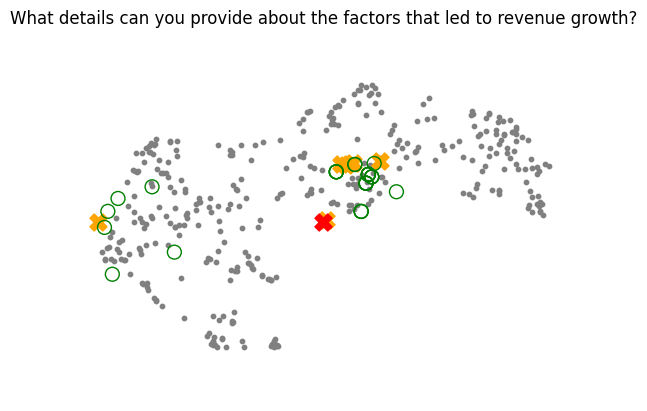

In [16]:

embeddings = chroma_collection.get(include=["embeddings"])["embeddings"]
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

# 4. We can also visualize the results in the embedding space
original_query_embedding = embedding_function([original_query])
augmented_query_embeddings = embedding_function(joint_query)


project_original_query = project_embeddings(original_query_embedding, umap_transform)
project_augmented_queries = project_embeddings(
    augmented_query_embeddings, umap_transform
)

retrieved_embeddings = results["embeddings"]
result_embeddings = [item for sublist in retrieved_embeddings for item in sublist]

projected_result_embeddings = project_embeddings(result_embeddings, umap_transform)

import matplotlib.pyplot as plt


# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(
    projected_dataset_embeddings[:, 0],
    projected_dataset_embeddings[:, 1],
    s=10,
    color="gray",
)
plt.scatter(
    project_augmented_queries[:, 0],
    project_augmented_queries[:, 1],
    s=150,
    marker="X",
    color="orange",
)
plt.scatter(
    projected_result_embeddings[:, 0],
    projected_result_embeddings[:, 1],
    s=100,
    facecolors="none",
    edgecolors="g",
)
plt.scatter(
    project_original_query[:, 0],
    project_original_query[:, 1],
    s=150,
    marker="X",
    color="r",
)

plt.gca().set_aspect("equal", "datalim")
plt.title(f"{original_query}")
plt.axis("off")
plt.show()  # display the plot

## Case-3: Reranking

Question:
what is the significance of CrossEncoder in sentence_transformers ?

Answer:
The `CrossEncoder` in the `sentence-transformers` library is a powerful model used for tasks that involve comparing pairs of sentences (or more generally, text inputs). It differs significantly from the more common `SentenceTransformer` model in how it handles and processes input, which directly impacts its accuracy and performance trade-offs.

---

### 🔍 **What is a CrossEncoder?**

In `sentence-transformers`, a `CrossEncoder`:

* **Takes two sentences (or pieces of text) as joint input** and feeds them together into a transformer model.
* **Does not encode the sentences independently** like `SentenceTransformer` (bi-encoder) models.
* Outputs a **single score or classification** for the pair, typically used for ranking or binary classification (e.g., "are these sentences similar?").

#### Example Use Case:

```python
from sentence_transformers import CrossEncoder

model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')
score = model.predict([("This is a sentence", "This is another sentence")])
```

---

### 🧠 **How It Works (vs. SentenceTransformer)**

| Feature              | `CrossEncoder`                               | `SentenceTransformer` (BiEncoder)        |
| -------------------- | -------------------------------------------- | ---------------------------------------- |
| Input Structure      | Joint sentence pair input                    | Independently encoded sentences          |
| Speed                | Slower (each pair must go through model)     | Very fast (precompute embeddings)        |
| Accuracy             | Higher (richer context with cross-attention) | Slightly lower for ranking tasks         |
| Embedding Generation | Not applicable                               | Yes, you get standalone sentence vectors |
| Use Case             | Classification, re-ranking                   | Semantic search, clustering              |

---

### 🎯 **When to Use CrossEncoder**

Use a `CrossEncoder` when:

* You need **maximum accuracy** (e.g., for re-ranking top results from a search).
* You are working with **classification tasks** over sentence pairs (e.g., NLI, similarity).
* You **don't need to precompute embeddings** or you're working with a small number of sentence pairs.

---

### ⚖️ Trade-Off Summary

| Situation                             | Recommended Model                          |
| ------------------------------------- | ------------------------------------------ |
| Large-scale semantic search           | `SentenceTransformer`                      |
| Small-scale or high-accuracy matching | `CrossEncoder`                             |
| Re-ranking top-k from a bi-encoder    | Use CrossEncoder after SentenceTransformer |

---

### 🛠 Practical Strategy

Often, you'll see them used **together**:

1. Use `SentenceTransformer` to quickly retrieve top-k candidate sentences.
2. Use `CrossEncoder` to **re-rank** these k candidates with high accuracy.

This balances speed and performance.


In [24]:
from helper_utils import word_wrap, load_chroma
from pypdf import PdfReader
import os
from openai import OpenAI
from dotenv import load_dotenv


from pypdf import PdfReader
import numpy as np

from langchain_community.document_loaders import PyPDFLoader


# Load environment variables from .env file
load_dotenv()

openai_key = os.getenv("OPENAI_API_KEY")
client = OpenAI(api_key=openai_key)


import chromadb
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

embedding_function = SentenceTransformerEmbeddingFunction()


reader = PdfReader("data/microsoft-annual-report.pdf")
pdf_texts = [p.extract_text().strip() for p in reader.pages]

# Filter the empty strings
pdf_texts = [text for text in pdf_texts if text]

from langchain.text_splitter import (
    RecursiveCharacterTextSplitter,
    SentenceTransformersTokenTextSplitter,
)

character_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", ". ", " ", ""], chunk_size=1000, chunk_overlap=0
)
character_split_texts = character_splitter.split_text("\n\n".join(pdf_texts))

token_splitter = SentenceTransformersTokenTextSplitter(
    chunk_overlap=0, tokens_per_chunk=256
)

token_split_texts = []
for text in character_split_texts:
    token_split_texts += token_splitter.split_text(text)

chroma_client = chromadb.Client()
chroma_collection = chroma_client.get_or_create_collection(
    "microsoft-collect", embedding_function=embedding_function
)

# extract the embeddings of the token_split_texts
ids = [str(i) for i in range(len(token_split_texts))]

chroma_collection.add(ids=ids, documents=token_split_texts)

count = chroma_collection.count()

query = "What has been the investment in research and development?"

results = chroma_collection.query(
    query_texts=query, n_results=10, include=["documents", "embeddings"]
)

retrieved_documents = results["documents"][0]

for document in results["documents"][0]:
    print(word_wrap(document))
    print("")

from sentence_transformers import CrossEncoder

cross_encoder = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2")

pairs = [[query, doc] for doc in retrieved_documents]
scores = cross_encoder.predict(pairs)

print("Scores:")
for score in scores:
    print(score)

print("New Ordering:")
for o in np.argsort(scores)[::-1]:
    print(o + 1)

original_query = (
    "What were the most important factors that contributed to increases in revenue?"
)

generated_queries = [
    "What were the major drivers of revenue growth?",
    "Were there any new product launches that contributed to the increase in revenue?",
    "Did any changes in pricing or promotions impact the revenue growth?",
    "What were the key market trends that facilitated the increase in revenue?",
    "Did any acquisitions or partnerships contribute to the revenue growth?",
]

# concatenate the original query with the generated queries
queries = [original_query] + generated_queries


results = chroma_collection.query(
    query_texts=queries, n_results=10, include=["documents", "embeddings"]
)
retrieved_documents = results["documents"]

# Deduplicate the retrieved documents
unique_documents = set()
for documents in retrieved_documents:
    for document in documents:
        unique_documents.add(document)

unique_documents = list(unique_documents)

pairs = []
for doc in unique_documents:
    pairs.append([original_query, doc])

scores = cross_encoder.predict(pairs)

print("Scores:")
for score in scores:
    print(score)

print("New Ordering:")
for o in np.argsort(scores)[::-1]:
    print(o)
# ====
top_indices = np.argsort(scores)[::-1][:5]
top_documents = [unique_documents[i] for i in top_indices]

# Concatenate the top documents into a single context
context = "\n\n".join(top_documents)

competitive in local markets and enables us to continue to attract top talent from acro
ss the world. we plan to continue to make significant investments in a broad range of p
roduct research and development activities, and as appropriate we will coordinate our r
esearch and development across operating segments and leverage the results across the c
ompany. in addition to our main research and development operations, we also operate mi
crosoft research. microsoft research is one of the world ’ s largest corporate research
 organizations, often working in close collaboration with top universities around the w
orld, and is focused on advancing the state - of - the - art in computer science and a 
broad range of other disciplines. our investment in fundamental research provides us a 
unique perspective on future trends and contributes to our innovation. distribution, sa
les, and marketing

our success is based on our ability to create new and compelling products, services, an
d experience

In [25]:
print(context)

fiscal year 2023 compared with fiscal year 2022 revenue increased $ 13. 6 billion or 7 % driven by growth in intelligent cloud and productivity and business processes, offset in part by a decline in more personal computing. intelligent cloud revenue increased driven by azure and other cloud services. productivity and business processes revenue increased driven by office 365 commercial and linkedin. more personal computing revenue decreased driven by windows and devices. cost of revenue increased $ 3. 2 billion or 5 % driven by growth in microsoft cloud, offset in part by the change in accounting estimate. gross margin increased $ 10. 4 billion or 8 % driven by growth in intelligent cloud and productivity and business processes and the change in accounting estimate, offset in part by a decline in more personal computing. • gross margin percentage increased slightly. excluding the impact of the change in accounting estimate,

• operating expenses increased $ 4. 2 billion or 21 % driven b

In [26]:
def generate_multi_query(query, context, model="gpt-3.5-turbo"):

    prompt = f"""
    You are a knowledgeable financial research assistant. 
    Your users are inquiring about an annual report. 
    """

    messages = [
        {
            "role": "system",
            "content": prompt,
        },
        {
            "role": "user",
            "content": f"based on the following context:\n\n{context}\n\nAnswer the query: '{query}'",
        },
    ]

    response = client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    content = content.split("\n")
    return content

In [27]:
res = generate_multi_query(query=original_query, context=context)
print("Final Answer:")
print(res)

Final Answer:
['The most important factors that contributed to increases in revenue for the fiscal year 2023 compared with fiscal year 2022 are as follows:', '', '1. Growth in Microsoft Cloud: Microsoft cloud revenue increased significantly by 22% to $111.6 billion. This growth was primarily driven by intelligent cloud services like Azure and other cloud services.', '', '2. Productivity and Business Processes: Revenue in this segment increased, particularly driven by Office 365 commercial and LinkedIn.', '', '3. Azure and Other Cloud Services: Revenue from Azure and other cloud services within the intelligent cloud segment experienced substantial growth.', '', '4. Dynamics 365: Revenue from Dynamics products and cloud services increased by 16%, mainly due to the growth of Dynamics 365.', '', '5. Office 365 Commercial: The growth of Office 365 commercial services contributed to the overall revenue increase in the productivity and business processes segment.', '', '6. Enterprise Services

##
Question: And what about NER, in which case we need to use it over CrossEncoder and other techniques ?

Answer:
Excellent — now you're thinking in terms of **matching the right tool to the right NLP task**, which is crucial for building effective systems.

Let’s focus on **NER (Named Entity Recognition)** and how it compares to using tools like `CrossEncoder`, `SentenceTransformer`, or general LLM-based pipelines.

---

## 🧠 **What is NER?**

NER is a **token-level task**:

* It identifies **entities** in text like people, organizations, dates, locations, etc.
* Example:

  > "Barack Obama was born in Hawaii."
  > → `Barack Obama` = PERSON, `Hawaii` = LOCATION

---

## 🔍 **How NER differs from CrossEncoder and SentenceTransformer**

| Task Type         | NER                                     | CrossEncoder / SentenceTransformer              |
| ----------------- | --------------------------------------- | ----------------------------------------------- |
| Granularity       | **Token-level**                         | **Sentence or pair-level**                      |
| Output            | List of entities + types                | Similarity score or classification label        |
| Use Cases         | Information extraction, knowledge graph | Sentence similarity, re-ranking, classification |
| Pretrained Models | SpaCy, Flair, HuggingFace Transformers  | SentenceTransformers, CrossEncoders             |
| Task Type         | **Structured prediction**               | **Pairwise reasoning / classification**         |

---

## ⚠️ **When NER is the right tool**

You should use **NER models** when your goal is to extract **structured information from unstructured text**.

### ✅ Use NER for:

* Pulling names, places, dates from news or medical records
* Creating knowledge bases from raw text
* Extracting key data for search or analytics
* Feeding entities into a graph database

### Example with SpaCy:

```python
import spacy

nlp = spacy.load("en_core_web_sm")
doc = nlp("Apple was founded by Steve Jobs in Cupertino.")
for ent in doc.ents:
    print(ent.text, ent.label_)
```

---

## ❌ When NOT to use NER

Don't use NER for:

* Measuring similarity between two sentences
* Classifying sentence pairs (e.g., entailment)
* Retrieving documents by meaning
* RAG pipelines (typically)

Those are handled much better by:

* ✅ `SentenceTransformer` (for dense semantic retrieval)
* ✅ `CrossEncoder` (for pairwise reranking or classification)
* ✅ LLMs / LangChain Agents (for reasoning or Q\&A)

---

## 🔁 How NER and CrossEncoder can **work together**

You can **combine NER with other techniques**:

| Goal                            | Tool Combo                        |
| ------------------------------- | --------------------------------- |
| Extract entities from documents | NER (e.g., SpaCy, transformers)   |
| Build search over entities      | `SentenceTransformer` + FAISS     |
| Rerank query results            | `CrossEncoder`                    |
| Answer questions from entities  | LangChain Agent + Retriever + NER |

So:

* **NER = extraction**
* **CrossEncoder = understanding/decision-making on pairs**
* **SentenceTransformer = retrieval and search**
* **LangChain = glue/brain to orchestrate all this**

---

## Summary

| Tool                    | Best For                              |
| ----------------------- | ------------------------------------- |
| **NER**                 | Extracting entities from raw text     |
| **CrossEncoder**        | Accurate scoring of sentence pairs    |
| **SentenceTransformer** | Fast semantic similarity or retrieval |
| **LangChain/Agents**    | Complex pipelines, reasoning, tools   |


## Case-3: Dense Passage Retrieval(DPR) Technique:

## 
Question: And what is DPR technique
Answer: 
Great question. Let's break down **DPR (Dense Passage Retrieval)** — a key technique in **dense retrieval-based QA systems**, especially useful in **Retrieval-Augmented Generation (RAG)**.

---

## 🧠 What is **DPR**?

**DPR (Dense Passage Retrieval)** is a technique introduced by Facebook AI (now Meta AI) in their 2020 paper:

> **"Dense Passage Retrieval for Open-Domain Question Answering"**
> [Karpukhin et al., 2020](https://arxiv.org/abs/2004.04906)

DPR aims to **efficiently retrieve relevant text passages** (documents or chunks) to answer a natural language question using **dense vector representations**, not keyword-based matching (like TF-IDF or BM25).

---

## 🔧 **How does DPR work?**

DPR uses two separate BERT-based encoders:

| Component                                                                                                                 | Description                            |
| ------------------------------------------------------------------------------------------------------------------------- | -------------------------------------- |
| **Question Encoder**                                                                                                      | Encodes the user's query into a vector |
| **Context Encoder**                                                                                                       | Encodes all passages into vectors      |
| ✅ **Key idea**: Both encoders are trained so that the query and relevant passage vectors are **close in embedding space** |                                        |

During retrieval:

1. Encode the query with the question encoder.
2. Search a vector index (e.g., FAISS) to find passages with the most similar embeddings.
3. Return top-k passages to an answer module (e.g., an LLM or reader model).

---

## 🧱 Architecture Overview

```
[Query] --> [Question Encoder] ---> [Query Embedding]
                                      |
                         +------------+------------+
                         |                         |
     [Passage A] --> [Context Encoder] --> [Vec A] |
     [Passage B] --> [Context Encoder] --> [Vec B] +--> Similarity Scores --> Top-K
     ...                                         |
     [Passage N] --> [Context Encoder] --> [Vec N] 
```

---

## 🚀 **Why DPR over traditional search (like BM25)?**

| Feature                        | Traditional (BM25)          | DPR                        |
| ------------------------------ | --------------------------- | -------------------------- |
| Matching method                | Exact or fuzzy word overlap | Semantic vector similarity |
| Synonym/semantic understanding | ❌ Poor                      | ✅ Strong                   |
| Speed                          | Fast                        | Fast (with FAISS)          |
| Training                       | ❌ No learning               | ✅ Can be fine-tuned        |
| Performance on QA              | Moderate                    | High (when tuned well)     |

---

## ✅ Use Cases for DPR

* Open-domain **Question Answering** systems (e.g., "Who discovered gravity?")
* **RAG** pipelines for LLMs (DPR handles retrieval, LLM handles generation)
* **Semantic search** where deep understanding of language is needed
* Academic or legal document search, tech support bots, etc.

---

## 🔬 DPR vs SentenceTransformer

| Feature            | DPR                                  | SentenceTransformer                   |
| ------------------ | ------------------------------------ | ------------------------------------- |
| Architecture       | Dual BERT encoders (query + passage) | Usually a single encoder (bi-encoder) |
| Training Objective | Contrastive (query-positive pairs)   | Similar (e.g., SimCSE, SBERT)         |
| Performance        | Very good for QA tasks               | More general-purpose embeddings       |
| Pretrained Models  | `facebook/dpr-*`                     | `sentence-transformers/*`             |
| Use in RAG         | Very common                          | Also common                           |

👉 **In practice**, SentenceTransformer can replicate or extend DPR (with more flexibility), and is often preferred in modern RAG setups due to ease of use and wider model variety.

---

## 🧪 Want to Try DPR?

Hugging Face has ready models:

```python
from transformers import DPRQuestionEncoder, DPRContextEncoder, DPRQuestionEncoderTokenizer, DPRContextEncoderTokenizer

question_encoder = DPRQuestionEncoder.from_pretrained('facebook/dpr-question_encoder-single-nq-base')
question_tokenizer = DPRQuestionEncoderTokenizer.from_pretrained('facebook/dpr-question_encoder-single-nq-base')

context_encoder = DPRContextEncoder.from_pretrained('facebook/dpr-ctx_encoder-single-nq-base')
context_tokenizer = DPRContextEncoderTokenizer.from_pretrained('facebook/dpr-ctx_encoder-single-nq-base')
```

---

## 🧠 Summary

* **DPR** is a dense retrieval technique using **dual encoders** for questions and passages.
* It's foundational in **RAG**, open-domain QA, and semantic search.
* Compared to older methods like BM25, it gives **much better semantic matching**.
* It can be used standalone or as part of a **hybrid retriever** with CrossEncoders and LLMs.

In [29]:
from transformers import (
    DPRQuestionEncoder,
    DPRContextEncoder,
    DPRQuestionEncoderTokenizer,
    DPRContextEncoderTokenizer,
)
import torch
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Load pre-trained DPR models and tokenizers
question_encoder = DPRQuestionEncoder.from_pretrained(
    "facebook/dpr-question_encoder-single-nq-base"
)
context_encoder = DPRContextEncoder.from_pretrained(
    "facebook/dpr-ctx_encoder-single-nq-base"
)
question_tokenizer = DPRQuestionEncoderTokenizer.from_pretrained(
    "facebook/dpr-question_encoder-single-nq-base"
)
context_tokenizer = DPRContextEncoderTokenizer.from_pretrained(
    "facebook/dpr-ctx_encoder-single-nq-base"
)

# Encode a query
# query = "capital of africa?" 
# o/p: Similarities: [[0.5736567  0.5479352  0.579875   0.57300705 0.5849962  0.46129072
#   0.36704734 0.36080304]]
# Most relevant passage: Maputo is the capital of Mozambique.
query = "Who invented the first computer"
question_inputs = question_tokenizer(query, return_tensors="pt")
question_embedding = question_encoder(**question_inputs).pooler_output

# Encode passages
passages = [
    "Paris is the capital of France.",
    "Berlin is the capital of Germany.",
    "Madrid is the capital of Spain.",
    "Rome is the capital of Italy.",
    "Maputo is the capital of Mozambique.",
    "To be or not to be, that is the question.",
    "The quick brown fox jumps over the lazy dog.",
    "Grace Hopper was an American computer scientist and United States Navy rear admiral. who was a pioneer of computer programming, and one of the first programmers of the Harvard Mark I computer. inventor of the first compiler for a computer programming language.",
]

context_embeddings = []
for passage in passages:
    context_inputs = context_tokenizer(passage, return_tensors="pt")
    context_embedding = context_encoder(**context_inputs).pooler_output
    context_embeddings.append(context_embedding)


context_embeddings = torch.cat(context_embeddings, dim=0)

# Compute similarities
similarities = cosine_similarity(
    question_embedding.detach().numpy(), context_embeddings.detach().numpy()
)
print("Similarities:", similarities)

# Get the most relevant passage
most_relevant_idx = np.argmax(similarities)
print("Most relevant passage:", passages[most_relevant_idx])


Some weights of the model checkpoint at facebook/dpr-question_encoder-single-nq-base were not used when initializing DPRQuestionEncoder: ['question_encoder.bert_model.pooler.dense.bias', 'question_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRQuestionEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DPRQuestionEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at facebook/dpr-ctx_encoder-single-nq-base were not used when initializing DPRContextEncoder: ['ctx_encoder.bert_model.pooler.dense.bias', 'ctx_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRContextEncoder from the

Similarities: [[0.39684945 0.42178315 0.45034823 0.44307727 0.38877854 0.47482723
  0.4102697  0.64571995]]
Most relevant passage: Grace Hopper was an American computer scientist and United States Navy rear admiral. who was a pioneer of computer programming, and one of the first programmers of the Harvard Mark I computer. inventor of the first compiler for a computer programming language.
